# 230118 Day102

## 문장 생성 모델 파인튜닝 하기
- 문장 생성 모델 만들기

In [ ]:
# 의존성 패키지 설치
!pip install ratsnlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.5/582.5 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 64.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=28137340977dae9e3fdf6e704721789a240e5da44eae417947b74d4c935ad2ed
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c1

In [ ]:
# 구글 드라이브와 연결
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
from torch.cuda import is_available

# 모델 환경 설정
import torch
from ratsnlp.nlpbook.generation import GenerationTrainArguments

args = GenerationTrainArguments(
    pretrained_model_name = "skt/kogpt2-base-v2",  # 40GB 이상의 텍스트로 학습된 한국어 디코더(decoder) 언어모델
    downstream_corpus_name = "nsmc",
    downstream_model_dir = "/gdrive/MyDrive/nlpbook/checkpoint-generation",
    max_seq_length=32,
    batch_size=32 if torch.cuda.is_available() else 4,
    learning_rate=5e-5,
    epochs=3,
    tpu_cores=0 if torch.cuda.is_available() else 8,
    seed=7,
)

In [ ]:
# 랜덤 시드 고정
from ratsnlp import nlpbook
nlpbook.set_seed(args)

set seed: 7


In [ ]:
# 로거 설정
nlpbook.set_logger(args)

INFO:ratsnlp:Training/evaluation parameters GenerationTrainArguments(pretrained_model_name='skt/kogpt2-base-v2', downstream_task_name='sentence-generation', downstream_corpus_name='nsmc', downstream_corpus_root_dir='/content/Korpora', downstream_model_dir='/gdrive/MyDrive/nlpbook/checkpoint-generation', max_seq_length=32, save_top_k=1, monitor='min val_loss', seed=7, overwrite_cache=False, force_download=False, test_mode=False, learning_rate=5e-05, epochs=3, batch_size=32, cpu_workers=12, fp16=False, tpu_cores=0)
INFO:ratsnlp:Training/evaluation parameters GenerationTrainArguments(pretrained_model_name='skt/kogpt2-base-v2', downstream_task_name='sentence-generation', downstream_corpus_name='nsmc', downstream_corpus_root_dir='/content/Korpora', downstream_model_dir='/gdrive/MyDrive/nlpbook/checkpoint-generation', max_seq_length=32, save_top_k=1, monitor='min val_loss', seed=7, overwrite_cache=False, force_download=False, test_mode=False, learning_rate=5e-05, epochs=3, batch_size=32, cpu

In [ ]:
# 말뭉치 다운로드
from Korpora import Korpora
Korpora.fetch(
    corpus_name=args.downstream_corpus_name,
    root_dir = args.downstream_corpus_root_dir,
    force_download=args.force_download,
)

[nsmc] download ratings_train.txt: 14.6MB [00:00, 91.5MB/s]                            
[nsmc] download ratings_test.txt: 4.90MB [00:00, 41.5MB/s]                            


In [ ]:
# 토크나이저 준비
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    args.pretrained_model_name,
    eos_token='</s>',
)

Downloading:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
# 학습 데이터셋 구축
from ratsnlp.nlpbook.generation import NsmcCorpus, GenerationDataset
corpus = NsmcCorpus()
train_dataset = GenerationDataset(
    args=args,
    corpus=corpus,
    tokenizer=tokenizer,
    mode='train'
)

INFO:ratsnlp:Creating features from dataset file at /content/Korpora/nsmc
INFO:ratsnlp:Creating features from dataset file at /content/Korpora/nsmc
INFO:ratsnlp:loading train data... LOOKING AT /content/Korpora/nsmc/ratings_train.txt
INFO:ratsnlp:loading train data... LOOKING AT /content/Korpora/nsmc/ratings_train.txt
INFO:ratsnlp:tokenize sentences, it could take a lot of time...
INFO:ratsnlp:tokenize sentences, it could take a lot of time...
INFO:ratsnlp:tokenize sentences [took 3.766 s]
INFO:ratsnlp:tokenize sentences [took 3.766 s]
INFO:ratsnlp:*** Example ***
INFO:ratsnlp:*** Example ***
INFO:ratsnlp:sentence: 부정 아 더빙.. 진짜 짜증나네요 목소리
INFO:ratsnlp:sentence: 부정 아 더빙.. 진짜 짜증나네요 목소리
INFO:ratsnlp:tokens: ▁부정 ▁아 ▁더 빙 .. ▁진짜 ▁짜 증 나 네 요 ▁목소리 </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
INFO:ratsnlp:tokens: ▁부정 ▁아 ▁더 빙 .. ▁진짜 ▁짜 증 나 네 요 ▁목소리 </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> <

In [ ]:
# 학습 데이터 로더 구축
from torch.utils.data import DataLoader, RandomSampler

train_dataloader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    sampler=RandomSampler(train_dataset, replacement=False),
    collate_fn=nlpbook.data_collator,
    drop_last=False,
    num_workers=args.cpu_workers, 
)

In [ ]:
# 평가용 데이터 구축
from torch.utils.data import SequentialSampler
val_dataset = GenerationDataset(
    args=args,
    corpus=corpus,
    tokenizer=tokenizer,
    mode='test',
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=args.batch_size,
    sampler=SequentialSampler(val_dataset),
    collate_fn=nlpbook.data_collator,
    drop_last=False,
    num_workers=args.cpu_workers,
) 

INFO:ratsnlp:Creating features from dataset file at /content/Korpora/nsmc
INFO:ratsnlp:Creating features from dataset file at /content/Korpora/nsmc
INFO:ratsnlp:loading test data... LOOKING AT /content/Korpora/nsmc/ratings_test.txt
INFO:ratsnlp:loading test data... LOOKING AT /content/Korpora/nsmc/ratings_test.txt
INFO:ratsnlp:tokenize sentences, it could take a lot of time...
INFO:ratsnlp:tokenize sentences, it could take a lot of time...
INFO:ratsnlp:tokenize sentences [took 1.664 s]
INFO:ratsnlp:tokenize sentences [took 1.664 s]
INFO:ratsnlp:*** Example ***
INFO:ratsnlp:*** Example ***
INFO:ratsnlp:sentence: 긍정 굳 ㅋ
INFO:ratsnlp:sentence: 긍정 굳 ㅋ
INFO:ratsnlp:tokens: ▁긍정 ▁굳 ▁ ᄏ </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
INFO:ratsnlp:tokens: ▁긍정 ▁굳 ▁ ᄏ </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>


In [ ]:
!cp -r /gdrive/MyDrive/CAKD8_Share/checkpoint-generation /gdrive/MyDrive/nlpbook/checkpoint-generation

In [ ]:
# 모델 초기화
from transformers import GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained(
    args.pretrained_model_name,
)

Downloading:   0%|          | 0.00/513M [00:00<?, ?B/s]

In [ ]:
# 태스크 정의
from ratsnlp.nlpbook.generation import GenerationTask
task = GenerationTask(model, args)

In [ ]:
# 트레이너 정의
trainer = nlpbook.get_trainer(args)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# 학습 개시
trainer.fit(
    task,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /gdrive/MyDrive/nlpbook/checkpoint-generation exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/core/optimizer.py:380: RuntimeWarning: Found unsupported keys in the optimizer configuration: {'scheduler'}
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type            | Params
------------------------------------------
0 | model | GPT2LMHeadModel | 125 M 
------------------------------------------
125 M     Trainable params
0         Non-trainable params
125 M     Total params
500.656   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## 프리트레인 마친 모델로 문장 생성하기
- GPT 모델로 문장 생성하기

In [ ]:
# 의존성 패키지 설치
#!pip install ratsnlp

In [ ]:
# 체크포인트 로드
from transformers import GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained(
    "skt/kogpt2-base-v2",
)

model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [ ]:
# 토크나이저 로드
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    "skt/kogpt2-base-v2",
    eos_token="</s>",
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
# 모델 입력값 만들기
input_ids = tokenizer.encode("안녕하세요", return_tensors="pt")

### 그리디 서치하기
- 매순간 최선(best)를 선택해 탐색 범위를 줄여보자는 것

- 빔 서치(beam search) : 빔(beam) 크기만큼의 선택지를 계산 범위에 포함

- 탑k 샘플링(top-k sampling) : 
  - 모델이 예측한 다음 토큰 확률 분포 에서 확률값이 가장 높은  k 개 토큰 가운데 하나를 다음 토큰으로 선택하는 기법. 
  - k개 안에 있는 단어라면 의자 같이 확률값이 낮은 케이스도 다음 토큰으로 추출될 수 있다.\
  따라서 탑k 샘플링은 매 시행 때마다 생성 결과가 달라진다.
  - top_k를 1로 입력한다면 do_sample 인자를 True로 두더라도 그리디 서치와 동일한 효과

- 템퍼러처 스케일링(temperature scaling) :
  - 모델의 다음 토큰 확률분포에 변형을 가해 문장을 다양하게 생성하는 기법
  - 확률분포를 변형한다는 의미는, 대소 관계의 역전 없이 분포의 모양만을 바꾼다는 의미
  - 이 값이 0에 가까울수록 확률분포 모양이 원래 대비 뾰족해 진다.\
  순위의 변동은 없지만 원래 컸던 확률은 더 커지고, 작았던 확률은 더 작아져 확률분포의 모양이 뾰족(sharp)해진다.\
  그만큼 확률값 기준 1등 토큰이 다음 토큰으로 뽑힐 가능성이 높아진다
  - temperature를 1보다 작게 하면 상대적으로 정확한 문장을, 1보다 크게 하면 상대적으로 다양한 문장을 생성한다.
  - 템퍼러처 스케일링은 탑k 샘플링, 탑p 샘플링과 같이 적용해야 의미가 있다

- 탑p 샘플링(top-p sampling) :
  - 확률값이 높은 순서대로 내림차순 정렬을 한 뒤 누적 확률값이  p 이하인 단어들 가운데 하나를 다음 단어로 선택하는 기법
  - 뉴클리어스 샘플링(necleus sampling)이라고도 불리며 확률값을 기준으로 단어들을 내림차순 정렬해 그 값이 높은 단어들을 후보로 삼는다는 점에서는 탑k 샘플링과 같지만 상위  k개를 후보로 삼느냐(탑k 샘플링), 누적 확률값이  p
  이하인 단어들을 후보로 삼느냐(탑p 샘플링)에 따라 차이

- 리피티션 패널티(repetition penalty)라는 방식으로 반복을 통제할 수도 있다.\
repetition_penalty 라는 인자를 주면 되고 그 값은 1.0 이상이어야 하며 클 수록 페널티가 세게 적용된다

#### Greedy Search
다음 단어 확률 분포에서 최대 확률을 내는 단어들을 리턴한다\
여러 번 수행하더라도 생성 결과가 바뀌지 않는다 (`do_sample=False`).

`max_length`는 생성 최대 길이이며 이보다 길거나, 짧더라도 EOD 토큰 등 스페셜 토큰이 나타나면 생성을 중단한다

`min_length`는 생성 최소 길이이며 이보다 짧은 구간에서 EOD 등 스페셜 토큰이 등장해 생성이 중단될 경우 해당 토큰이 나올 확률을 0으로 수정하여 문장 생성이 종료되지 않도록 강제한다.

In [ ]:
# 그리디 서치
import torch
with torch.no_grad():
  generated_ids = model.generate(
      input_ids,
      do_sample=False,  # 확률값이 높은 단어를 다음 단어로 결정
      min_length=10,
      max_length=50,
  )

# 토큰 인덱스를 문장으로 복원하기 (그리디 서치 수행 결과 출력)
print(tokenizer.decode([el.item() for el in generated_ids[0]]))

안녕하세요?"
"그럼, 그건 뭐예요?"
"그럼, 그건 뭐예요?"
"그럼, 그건 뭐예요?"
"그럼, 그건 뭐예요?"



#### Beam Search 
Beam Search는 다음 단어 확률 분포에서 `num_beams`만큼의 경우의 수를 남겨가면서 문장을 생성한다.\
Greedy search보다 계산량이 많지만 좀 더 확률값이 높은 문장을 생성할 수 있다.

In [ ]:
# 빔 서치
with torch.no_grad():
  generated_ids = model.generate(
      input_ids,
      do_sample=False,  # 확률값이 높은 단어를 다음 단어로 결정
      min_length=10,
      max_length=50,
      num_beams=3,   # 빔 크기를 3으로 지정 (숫자를 바꿔가며 실행해보기)
  )

# 빔 서치 수행 결과
print(tokenizer.decode([el.item() for el in generated_ids[0]]))

안녕하세요?"
"그렇지 않습니다."
"그렇지 않습니다."
"그렇지 않습니다."
"그렇지 않습니다."
"그렇지 않습니다."
"그렇지 않습니다."
"그


#### 반복 줄이기
* 반복되는 n-gram 사이즈를 지정하기
 - 위의 예시를 보면 `"그럼, 그건 뭐예요?"`이 반복됩니다. 이를 아래와 같이 지정해 반복을 방지합니다.
 - 3개 이상의 토큰이 반복될 경우 해당 3-gram 등장 확률을 0으로 만들어 생성 결과에서 배제합니다.

In [ ]:
# 반복 줄이기 (1)
with torch.no_grad():
  generated_ids = model.generate(
      input_ids,
      do_sample=False,
      min_length=10,
      max_length=50,
      no_repeat_ngram_size=3,   # 토큰이 3개 이상 반복될 경우 3번째 토큰 확률을 0 으로 변경
  )

#### repetition penalty

repetition penalty로 반복을 통제할 수도 있습니다.\
다음과 같이 실행하면 되며 그 범위는 '1 이상의 값' 을 가져야 합니다.\
1이라면 아무런 패널티를 적용하지 않는게 됩니다.

In [ ]:
# 반복 줄이기 (2)
with torch.no_grad():
  generated_ids = model.generate(
      input_ids,
      do_sample=False,
      min_length=10,
      max_length=50,
      repetition_penalty=1.0,   # 리피티션 패널티 적용 (1.1, 1.2 로 적용해보기)
  )

print(tokenizer.decode([el.item() for el in generated_ids[0]]))

안녕하세요?"
"그럼, 그건 뭐예요?"
"그럼, 그건 뭐예요?"
"그럼, 그건 뭐예요?"
"그럼, 그건 뭐예요?"



In [ ]:
# 반복 줄이기 (2) - repetition_penalty=1.1
with torch.no_grad():
  generated_ids = model.generate(
      input_ids,
      do_sample=False,
      min_length=10,
      max_length=50,
      repetition_penalty=1.1,   # 리피티션 패널티 적용 (1.1, 1.2 로 적용해보기)
  )

print(tokenizer.decode([el.item() for el in generated_ids[0]]))

안녕하세요?"
"그럼, 그건 뭐예요?"
"아니요, 저는요."
"그럼, 그건 무슨 말씀이신지요?"
"그럼, 그건 뭐예요?"



In [ ]:
# 반복 줄이기 (2) - repetition_penalty=1.2
with torch.no_grad():
  generated_ids = model.generate(
      input_ids,
      do_sample=False,
      min_length=10,
      max_length=50,
      repetition_penalty=1.2,   # 리피티션 패널티 적용 (1.1, 1.2 로 적용해보기)
  )

print(tokenizer.decode([el.item() for el in generated_ids[0]]))

안녕하세요?"
"그럼, 그건 뭐예요, 아저씨. 저는 지금 이 순간에도 괜찮아요."
"그래서 오늘은 제가 할 수 있는 일이 무엇인지 말해 보겠습니다."
"이제


In [ ]:
# 반복 줄이기 (2) - repetition_penalty=1.5
with torch.no_grad():
  generated_ids = model.generate(
      input_ids,
      do_sample=False,
      min_length=10,
      max_length=50,
      repetition_penalty=1.5,   # 리피티션 패널티 적용 (1.1, 1.2 로 적용해보기)
  )

print(tokenizer.decode([el.item() for el in generated_ids[0]]))

안녕하세요?"
"그럼, 그건 뭐예요, 아저씨. 저는 지금 이 순간에도 괜찮아요. 그리고 제가 할 수 있는 일은 아무것도 없어요.
이제 그만 돌아가고 싶어요.
제가 하는 일이 무엇


#### top-k sampling

지금까지는 생성을 반복하더라도 그 결과가 동일한 샘플링 방식을 살펴봤습니다.\
top-k sampling은 다음 단어를 뽑을 때 확률값 기준 가장 큰 k개 가운데 하나를 선택하는 기법입니다.\
확률값이 큰 단어가 다음 단어로 뽑힐 가능성이 높아지지만,\
k개 안에 있는 단어라면 확률값이 낮더라도 다음 단어로 추출될 수 있습니다.\
따라서 top-k sampling은 매 시행 때마다 생성 결과가 달라집니다.\
k는 1 이상의 값을 지녀야 합니다.

In [ ]:
# 탑-k 샘플링
with torch.no_grad():
  generated_ids = model.generate(
      input_ids,
      do_sample=True,  # 샘플링 방식으로 다음 토큰 생성
      min_length=10,
      max_length=50,
      top_k=50,   # k를 50으로 탑-k 샘플링 수행
  )

print(tokenizer.decode([el.item() for el in generated_ids[0]]))

안녕하세요?!!
예~~ 예. 제발! 그래요..
예. 근데 또 이게 이쁘지 않나요?!?!
여튼 지금 뭔가 열심히 하는데요?!
어쨌건!


#### top-k sampling + temperature scaling

top-k sampling은 temperature scaling과 동시에 적용할 수 있습니다. 그 값에 따라 다음과 같은 효과가 납니다.

(1) t가 0에 가까워질수록 토큰 분포가 sharp해진다 > 1등 토큰이 뽑힐 확률이 그만큼 높아진다 > do_sample=True 이지만 사실상 greedy decoding 이 된다

In [ ]:
with torch.no_grad():
  generated_ids = model.generate(
      input_ids,
      do_sample=True,
      min_length=10,
      max_length=50,
      top_k=50,
      temperature=0.01,
  )

print(tokenizer.decode([el.item() for el in generated_ids[0]]))

안녕하세요?"
"그럼, 그건 뭐예요?"
"그럼, 그건 뭐예요?"
"그럼, 그건 뭐예요?"
"그럼, 그건 뭐예요?"



(2) t=1 이라면 모델 출력 분포를 그대로 사용한다 > 하지만 샘플링 방식을 사용하기 때문에 생성할 때마다 다른 문장이 나온다

In [ ]:
with torch.no_grad():
  generated_ids = model.generate(
      input_ids,
      do_sample=True,
      min_length=10,
      max_length=50,
      top_k=50,
      temperature=1.0,
  )

print(tokenizer.decode([el.item() for el in generated_ids[0]]))

안녕하세요?"
"예, 예. 저는, 고마워요. 내일 오후에 만나죠."
"예, 예, 고마워요."
내가 말끝을 흐렸다.
"아무쪼록, 저도 이만 가볼


(3) t를 키울수록 토큰 분포가 uniform 해진다 > 사실상 uniform sampling 이 된다, 생성 품질이 악화할 가능성이 높아진다

In [ ]:
# 실행할 때마다 다른 문장 생성
with torch.no_grad():
  generated_ids = model.generate(
      input_ids,
      do_sample=True,
      min_length=10,
      max_length=50,
      top_k=50,
      temperature=100000000.0,
  )

print(tokenizer.decode([el.item() for el in generated_ids[0]]))

안녕하세요라고 하면 아플 일이죠.
자 제가 이렇게 궁금해지는 쵸 네 사실 네 그 요즘 너무 막 제가 안 해 볼 생각이 돼 가지신 아 쩜 안 좋다가 요러지고 어르케 네 한 이백이백 


#### top-p sampling

top-p sampling은 다음 단어를 뽑을 때 누적 확률값이 p 이하인 단어들 가운데 하나를 선택하는 기법이다.\
확률값이 큰 단어가 다음 단어로 뽑힐 가능성이 높아지지만,\
누적 확률값 p 이하에 있는 단어라면 확률값이 낮더라도 다음 단어로 추출될 수 있다.

따라서 top-p sampling은 매 시행 때마다 생성 결과가 달라진다

p는 확률이기 때문에 0~1 사이의 값을 지녀야 한다.\
p가 1이라면 어휘 집합에 있는 모든 단어를 대상으로 샘플링하기 때문에 top-p sampling 효과가 사라진다.\
p가 1보다 약간 작다면 확률값이 낮은 일부 단어들을 다음 단어 후보에서 제거해 생성 품질을 높인다.

In [ ]:
# 탑-p 샘플링 (1)
with torch.no_grad():
  generated_ids = model.generate(
      input_ids,
      do_sample=True,
      min_length=10,
      max_length=50,
      top_p=0.92,
  )

print(tokenizer.decode([el.item() for el in generated_ids[0]]))

안녕하세요?"
"네! 저는 이렇게 뵙겠습니다."
"그래서 이렇게 하죠."
오가는 부인에게 말을 걸었다.
"내가 이렇게 해주었으니 얼마나 다행인가. 정말."
"그렇다면 우리도 기꺼이


p가 0에 가까울 경우 Greed search 와 비슷해진다

In [ ]:
# 탑-p 샘플링 (1) - top_p=0.01
with torch.no_grad():
  generated_ids = model.generate(
      input_ids,
      do_sample=True,
      min_length=10,
      max_length=50,
      top_p=0.01,
  )

print(tokenizer.decode([el.item() for el in generated_ids[0]]))

안녕하세요?"
"그럼, 그건 뭐예요?"
"그럼, 그건 뭐예요?"
"그럼, 그건 뭐예요?"
"그럼, 그건 뭐예요?"



### 통합적용

In [ ]:
with torch.no_grad():
  generated_ids = model.generate(
      input_ids,
      do_sample=True,  # 샘플링 방식 적용
      min_length=10,   # 문장 길이 설정
      max_length=50,
      repetition_penalty=1.5,  # 반복 줄이기
      no_repeat_ngram_size=3,  # 반복 줄이기
      temperature=0.9,         # 탬퍼러처 스케일링
      top_k=50,
      top_p=0.92,
  )

print(tokenizer.decode([el.item() for el in generated_ids[0]]))

안녕하세요?' 하고 반문한 뒤 다시 그 자리에 주저앉았다.
이제는 아무 생각 없이 말을 이었다.
"미안해요. 하지만 저는 우리 당신들이 잘못했어요, 제발!"
나는 고개를 끄덕였다.
하지만


## 파인튜닝 마친 모델로 문장 생성하기
- 문장 생성 웹서비스

In [ ]:
# 인퍼런스 설정
from ratsnlp.nlpbook.generation import GenerationDeployArguments
args = GenerationDeployArguments(
    pretrained_model_name="skt/kogpt2-base-v2",   # 파인튜닝 때 사용한 프리트레인을 마친 모델
    downstream_model_dir="/gdrive/MyDrive/nlpbook/checkpoint-generation"   # 파인튜닝한 모델의 저장 위치
)

downstream_model_checkpoint_fpath: /gdrive/MyDrive/nlpbook/checkpoint-generation/epoch=1-val_loss=2.29-v1.ckpt


In [ ]:
# 토크나이저 초기화
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    args.pretrained_model_name,
    eos_token="</s>",
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
# 모델 불러오기
import torch
from transformers import GPT2Config, GPT2LMHeadModel
pretrained_model_config = GPT2Config.from_pretrained(
    args.pretrained_model_name,
)

model = GPT2LMHeadModel(pretrained_model_config)
fine_tuned_model_ckpt = torch.load(
    args.downstream_model_checkpoint_fpath,
    map_location=torch.device("cpu")
)

model.load_state_dict({k.replace("model.", ""): v for k, v in fine_tuned_model_ckpt['state_dict'].items()})
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [ ]:
# 인퍼런스
def inference_fn(
    prompt,
    min_length=10,
    max_length=20,
    top_p=1.0,
    top_k=50,
    repetition_penalty=1.0,
    no_repeat_ngram_size=0,
    temperature=1.0,):
  
  try:
    input_ids=tokenizer.encode(prompt, return_tensors="pt")  # prompt 를 토큰화하고 인덱싱한 뒤 파이토치 텐서로 만들기
    with torch.no_grad():
      generated_ids = model.generate(
          input_ids,
          do_sample=True,
          top_p=float(top_p),
          top_k=int(top_k),
          min_length=int(min_length),
          max_length=int(max_length),
          repetition_penalty=float(repetition_penalty),
          no_repeat_ngram_size=int(no_repeat_ngram_size),
          temperature=float(temperature),
      )

    generated_sentence = tokenizer.decode([el.item() for el in generated_ids[0]])

  except:
    generated_sentence = """처리 중 오류가 발생했습니다. <br>
          변수의 입력 범위를 확인하세요. <br><br>
          min_length: 1 이상의 정수 <br>
          max_length: 1 이상의 정수 <br>
          top-p: 0 이상 1 이하의 실수 <br>
          top-k: 1 이상의 정수 <br>
          repetition_penalty: 1 이상의 실수 <br>
          no_repeat_ngram_size: 1 이상의 정수 <br>
          temperature: 0 이상의 실수
          """

  return {
      'result' : generated_sentence,
  }

## 웹서비스

In [ ]:
!rm -rf /root/.ngrok2/

In [ ]:
!ls /root -al

total 64
drwx------ 1 root root 4096 Jan 18 01:29 .
drwxr-xr-x 1 root root 4096 Jan 18 01:20 ..
-r-xr-xr-x 1 root root 1169 Jan  1  2000 .bashrc
drwxr-xr-x 1 root root 4096 Jan 18 01:20 .cache
drwx------ 1 root root 4096 Jan 18 01:20 .config
drwxr-xr-x 5 root root 4096 Jan 13 14:45 .ipython
drwx------ 2 root root 4096 Jan 13 14:45 .jupyter
drwxr-xr-x 2 root root 4096 Jan 13 14:44 .keras
drwxr-xr-x 1 root root 4096 Jan 13 14:45 .local
drwxr-xr-x 4 root root 4096 Jan 13 14:46 .npm
drwx------ 3 root root 4096 Jan 18 01:29 .nv
-rw-r--r-- 1 root root  161 Dec  5  2019 .profile
-r-xr-xr-x 1 root root  254 Jan  1  2000 .tmux.conf
-rw-r--r-- 1 root root  165 Jan 13 14:45 .wget-hsts


In [ ]:
!mkdir /root/.ngrok2 && echo "authtoken: 2K7ID8ZcT7kK16cuvUNOrYHgoxc_81tzFhnzDzLHatQ7xguDQ" > /root/.ngrok2/ngrok.yml

In [ ]:
!ls /root -al

total 68
drwx------ 1 root root 4096 Jan 18 03:17 .
drwxr-xr-x 1 root root 4096 Jan 18 01:20 ..
-r-xr-xr-x 1 root root 1169 Jan  1  2000 .bashrc
drwxr-xr-x 1 root root 4096 Jan 18 01:20 .cache
drwx------ 1 root root 4096 Jan 18 01:20 .config
drwxr-xr-x 5 root root 4096 Jan 13 14:45 .ipython
drwx------ 2 root root 4096 Jan 13 14:45 .jupyter
drwxr-xr-x 2 root root 4096 Jan 13 14:44 .keras
drwxr-xr-x 1 root root 4096 Jan 13 14:45 .local
drwxr-xr-x 2 root root 4096 Jan 18 03:17 .ngrok2
drwxr-xr-x 4 root root 4096 Jan 13 14:46 .npm
drwx------ 3 root root 4096 Jan 18 01:29 .nv
-rw-r--r-- 1 root root  161 Dec  5  2019 .profile
-r-xr-xr-x 1 root root  254 Jan  1  2000 .tmux.conf
-rw-r--r-- 1 root root  165 Jan 13 14:45 .wget-hsts


In [ ]:
# 웹서비스
from ratsnlp.nlpbook.generation import get_web_service_app
app = get_web_service_app(inference_fn)
app.run()

 * Serving Flask app "ratsnlp.nlpbook.generation.deploy" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://e23d-34-27-108-92.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 03:18:34] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 03:18:35] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 03:19:02] "POST /api HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 03:19:07] "POST /api HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 03:19:51] "POST /api HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 03:19:57] "POST /api HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 03:20:05] "POST /api HTTP/1.1" 200 -


# 230119 Day103

## 인코딩(encoding)과 디코딩(decoding)
https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/autoencoder.ipynb

- 인코딩-디코딩 아키텍쳐는 통신, 암호, 전자 등 다양한 분야에 적용되는 일반적인 프레임워크

- 인코더는 입력 샘플을 잠재 공간, 즉 인코더에 의해 정의된 숨겨진 구조화된 값 집합에 매핑하는 함수

- 디코더는 이 잠재 공간의 요소를 사전 정의된 타겟 도메인으로 매핑하는 여함수

- 예를 들어, 이미지와 오디오 압축 포맷

  - JPEG 도구는 미디어 파일을 가벼운 이진파일로 압축하여 인코딩하고, 표시할 떄 픽셀 값을 복원하기 위해 디코딩

  <img src="https://image.slidesharecdn.com/aes171113-180510014736/95/-48-638.jpg?cb=1525916931">

  <sub>[이미지 출처] https://www.slideshare.net/NaverEngineering/ss-96581209</sub>

## 오토인코더(Autoencoder, AE)

- 입력을 저차원 잠재공간으로 인코딩한 후 디코딩하여 복원하는 네트워크  
  즉, 이미지를 입력받아 인코더 모듈을 사용하여 잠재 벡터 공간으로 매핑하고,  
  디코더 모듈을 사용하여 원본 이미지와 동일한 차원으로 복원하여 출력

- 원본 입력을 재구성하는 방법으로 학습

- 고전적인 방식은 구조화가 잘된 잠재 공간을 만들지 못하고,  
  압축도 뛰어나지 않음

  <img src="https://miro.medium.com/max/1200/1*nqzWupxC60iAH2dYrFT78Q.png">

  <sub>[이미지 출처] https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f</sub>

In [ ]:
# TensorFlow 및 기타 라이브러리 가져오기
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
# 데이터 세트 로드

# 입력값과 출력값이 같으므로 x_train, x_test 만 사용
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


### 첫 번째 예: 기본 autoencoder

[기본 오토 인코더 결과](https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/images/intro_autoencoder_result.png?raw=1)

두 개의 Dense 레이어로 autoencoder를 정의합니다.\
이미지를 64차원 잠재 벡터로 압축하는 `encoder`와 잠재 공간에서 원본 이미지를 재구성하는 `decoder`입니다.

모델을 정의하려면 [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models)를 사용하세요.

In [ ]:
# 첫번째 예 : 기본 autoencoder
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
        layers.Dense(units=784, activation='sigmoid'),
        layers.Reshape((28,28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)

    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
# 모델 훈련 : x_train 을 입력과 대상으로 사용하여 모델 훈련
# encoder 는 데이터세트를 784 차원에서 잠재공간으로 압축하는 방법을 배우고,
# decoder 는 원본 이미지를 재구성하는 방법을 배운다

autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 7s 2ms/step - loss: 0.0241 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0118 - val_loss: 0.0108
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.008

In [ ]:
# 테스트 세트에서 이미지를 인코딩 및 디코딩
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

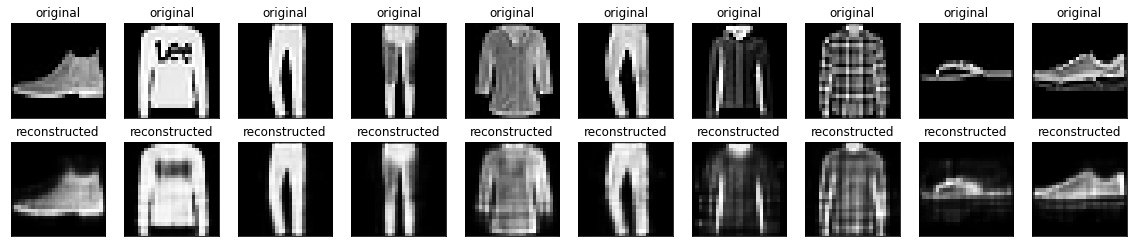

In [ ]:
n = 10

plt.figure(figsize=(20,4))

for i in range(n):
  # display original
  ax = plt.subplot(2, n, i+1)
  plt.imshow(x_test[i])
  plt.title('original')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(decoded_imgs[i])
  plt.title('reconstructed')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

### 두번째 예 : 이미지 노이즈 제거
이미지 노이즈 제거 결과

autoencoder는 이미지에서 노이즈를 제거하도록 훈련될 수도 있습니다. 다음 섹션에서는 각 이미지에 임의의 노이즈를 적용하여 Fashion MNIST 데이터세트의 노이즈 버전을 생성합니다. 그런 다음 노이즈가 있는 이미지를 입력으로 사용하고 원본 이미지를 대상으로 사용하여 autoencoder를 훈련합니다.

이전에 수정한 내용을 생략하기 위해 데이터세트를 다시 가져오겠습니다.

In [ ]:
# 다시 데이터 세트 로드

# 입력값과 출력값이 같으므로 x_train, x_test 만 사용
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# [] 안에 기존의 배열을 '...' 으로 적고, 추가하고 싶은 위치에 tf.newaxis 를 적어주면 간단하게 사이즈 변경이 된다
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
# 이미지에 임의의 노이즈 추가
noise_factor = 0.2

x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

# clip_by_value() : Tensor 값을 지정된 최소값과 최대값으로 자르는 데 사용
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

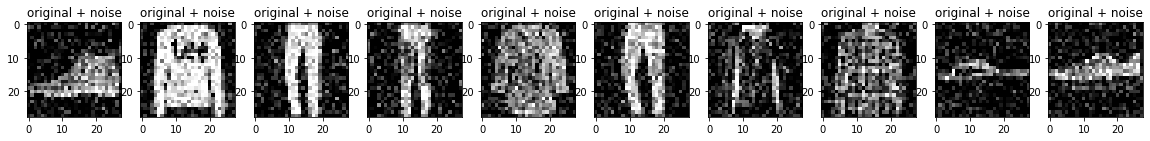

In [ ]:
# 노이즈가 있는 이미지 플롯
n = 10

plt.figure(figsize=(20,2))
for i in range(n):
  ax = plt.subplot(1, n, i+1)
  plt.title('original + noise')
  plt.imshow(tf.squeeze(x_test_noisy[i]))   # tf.sqeeze() : 차원 축소, 크기가 1인 차원만 제거
  plt.gray()

plt.show()

#### 컨볼루셔널 autoencoder 정의하기
이 예제에서는 encoder에 Conv2D 레이어를 사용하고 decoder에 Conv2DTranspose 레이어를 사용하여\
컨볼루셔널 autoencoder를 훈련합니다.

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', strides=2),
        layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', strides=2)
    ])

    self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(filters=8, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)

    return decoded

autoencoder = Denoise()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
# 입력은 noise 가 있는 것으로, 출력은 원본으로 --> 노이즈가 제거되어 나온다
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 13s 3ms/step - loss: 0.0180 - val_loss: 0.0099
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.00

In [ ]:
# encoder 의 요약 : 이미지가 28x28 에서 어떻게 다운 샘플링 되는지 확인
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# decoder 의 요약 : 이미지를 7x7에서 28x28로 다시 업샘플링
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        145       
 ranspose)                                                       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# autoencoder에서 생성된 노이즈가 있는 이미지와 노이즈가 제거 된 이미지를 모두 플롯
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

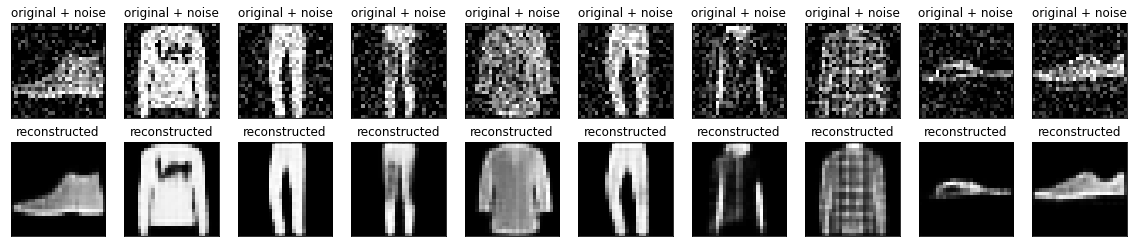

In [ ]:
n = 10

plt.figure(figsize=(20,4))

for i in range(n):
  # display original + noise
  ax = plt.subplot(2, n, i+1)
  plt.title('original + noise')
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstrucation
  bx = plt.subplot(2, n, i+n+1)
  plt.title('reconstructed')
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  plt.gray()
  bx.get_xaxis().set_visible(False)
  bx.get_yaxis().set_visible(False)

plt.show()

### 세 번째 예: 이상 감지

이 예에서는 [ECG5000 데이터세트](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)에서 이상을 감지하도록 autoencoder를 훈련합니다. 이 데이터세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 [심전도](https://en.wikipedia.org/wiki/Electrocardiography)가 포함되어 있습니다. 단순화 된 버전의 데이터세트를 사용하고, 각 예제는 `0`(비정상 리듬에 해당) 또는 `1`(정상 리듬에 해당)으로 레이블이 지정됩니다. 여러분은 비정상 리듬을 식별하는 데 관심이 있습니다.

참고: 레이블이 지정된 데이터세트를 사용하므로 지도 학습 문제라고 표현할 수 있습니다. 이 예의 목표는 사용 가능한 레이블이 없는 더 큰 데이터세트에 적용할 수 있는 이상 감지 개념을 설명하는 것입니다(예: 정상 리듬이 수천 개이고 비정상 리듬이 적은 경우).

autoencoder를 사용하여 이상을 어떻게 감지하겠습니까? autoencoder는 재구성 오류를 최소화하도록 훈련되었습니다. autoencoder는 정상 리듬으로만 훈련한 다음 이 autoencoder를 사용하여 모든 데이터를 재구성합니다. 여기서 가설은 비정상 리듬의 경우에 재구성 오류가 더 클 것이라는 것입니다. 그런 다음 재구성 오류가 고정 임계값을 초과하는 경우, 리듬을 이상으로 분류합니다.

보충 설명 : https://blog.daum.net/ejleep1/1227

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
# ECG 데이터 로드 (https://www.tensorflow.org/tutorials/generative/autoencoder?hl=ko)
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv')
raw_data = dataframe.values
dataframe.head()

,-0.11252183,-2.8272038,-3.7738969,-4.3497511,-4.376041,-3.4749863,-2.1814082,-1.8182865,-1.2505219,-0.47749208,...,0.79216787,0.93354122,0.79695779,0.57862066,0.2577399,0.22807718,0.12343082,0.92528624,0.19313742,1.0
0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
1,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
2,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
3,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
4,-1.507674,-3.574550,-4.478011,-4.408275,-3.321242,-2.105171,-1.481048,-1.301362,-0.498240,-0.286928,...,1.089068,0.983369,1.014124,0.952629,0.749326,1.007076,1.634990,1.493365,-0.783134,1.0


In [ ]:
dataframe.shape

(4997, 141)

In [ ]:
dataframe.iloc[:, -1].value_counts()

1.0    2918
0.0    2079
Name: 1.0, dtype: int64

In [ ]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [ ]:
# 데이터를 [0,1] 로 정규화
# tf.cast() : 텐서를 새로운 형대로 캐스팅하는데에 사용
# float 형에서 int 형으로 바꾸는 경우 '소수점 버림' 을 한다
# Boolean 형태인 경우 True 이면 1, False 이면 0 출력

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
print(train_data.shape)
print(train_labels.shape)

(3997, 140)
(3997,)


In [ ]:
# 1로 레이블이 지정된 정상 리듬만 사용하여 autoencoder 훈련
# 정상 리듬과 비정상 리듬을 분리
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

# '~' : 부정의 의미
anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [ ]:
pd.Series(train_labels).value_counts()

True     2354
False    1643
dtype: int64

In [ ]:
normal_train_data.shape

TensorShape([2354, 140])

In [ ]:
# 정상적인 ECG 플롯
normal_train_data[0]

<tf.Tensor: shape=(140,), dtype=float32, numpy=
array([0.58314776, 0.59827954, 0.4776676 , 0.31911346, 0.24140912,
       0.16393512, 0.18975276, 0.2769952 , 0.3331578 , 0.33897957,
       0.4173438 , 0.46848902, 0.45449716, 0.45726457, 0.44885635,
       0.45364085, 0.45625016, 0.45393726, 0.44098073, 0.4424002 ,
       0.43785232, 0.4431749 , 0.43611535, 0.42878932, 0.4391552 ,
       0.4306156 , 0.42506462, 0.41547662, 0.4198088 , 0.41354203,
       0.409676  , 0.40778282, 0.3989176 , 0.3968773 , 0.38809443,
       0.38096437, 0.38673082, 0.38237065, 0.38300553, 0.37988606,
       0.37757277, 0.38209563, 0.38468045, 0.39033654, 0.39327672,
       0.39583132, 0.40870225, 0.42886585, 0.42880708, 0.44032052,
       0.44974694, 0.4364933 , 0.4493361 , 0.4501428 , 0.45988372,
       0.45766976, 0.45526138, 0.46120256, 0.4620118 , 0.46540666,
       0.47176513, 0.46878478, 0.4610575 , 0.4673105 , 0.46668088,
       0.47246215, 0.48169366, 0.48182917, 0.48392007, 0.4809443 ,
       0.48260

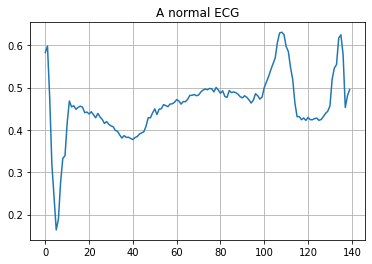

In [ ]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title('A normal ECG')
plt.show()

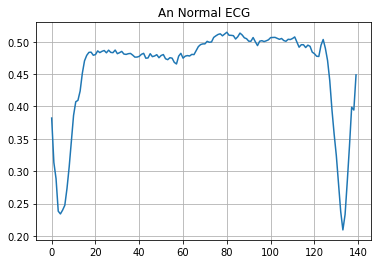

In [ ]:
# 비정상적인 ECG 플롯
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title('An Normal ECG')
plt.show()

#### 모델 빌드하기

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
# autoencoder 는 일반 ECG만 사용하여 훈련되지만, 전체 테스트세트를 사용하여 평가된다
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 36ms/step - loss: 0.0579 - val_loss: 0.0528
Epoch 2/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0554 - val_loss: 0.0511
Epoch 3/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0525 - val_loss: 0.0496
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0493 - val_loss: 0.0480
Epoch 5/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0459 - val_loss: 0.0459
Epoch 6/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0426 - val_loss: 0.0442
Epoch 7/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0393 - val_loss: 0.0429
Epoch 8/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0363 - val_loss: 0.0416
Epoch 9/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0336 - val_loss: 0.0405
Epoch 10/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0312 - val_loss: 0.0395
Epoch 11/20
5/5 [=====================

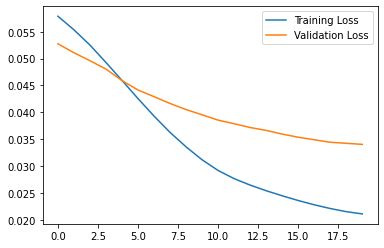

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

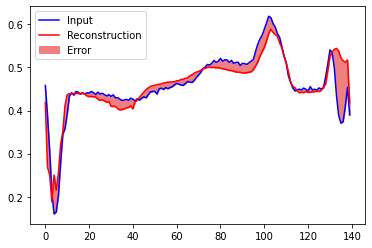

In [ ]:
# 재구성 오류가 정상 훈련 예제에서 하나의 표준 편차보다 큰 경우, ECG를 비정상으로 분류
# 훈련 세트의 정상 ECG, autoencoder에 의해 인코딩 및 디코딩된 후의 재구성, 재구성 오류를 플롯

encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])

plt.show()

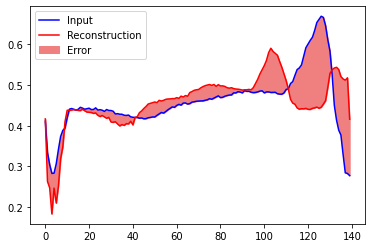

In [ ]:
# 비정상적인 테스트 예제에서 비슷한 플롯 생성

encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])

plt.show()

#### 이상 감지하기

74/74 [==============================] - 0s 1ms/step


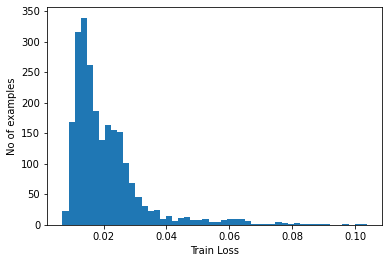

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel('Train Loss')
plt.ylabel('No of examples')
plt.show()

In [ ]:
# 평균보다 표준편차가 높은 임계값 선택
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)     

Threshold:  0.033035938


14/14 [==============================] - 0s 1ms/step


(array([ 1.,  0.,  4.,  2.,  7., 18., 32., 57., 91., 83., 53., 37., 25.,
        14.,  5.,  1.,  3.,  0.,  0.,  3.]),
 array([0.02174278, 0.02485341, 0.02796404, 0.03107467, 0.03418531,
        0.03729594, 0.04040657, 0.04351719, 0.04662783, 0.04973846,
        0.05284909, 0.05595972, 0.05907035, 0.06218098, 0.06529161,
        0.06840224, 0.07151287, 0.0746235 , 0.07773413, 0.08084476,
        0.08395539], dtype=float32),
 <a list of 20 Patch objects>)

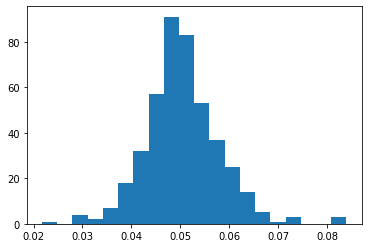

In [ ]:
# 임계값을 변경하여 분류자의 정밀도와 재현율을 조정
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=20)

In [ ]:
# 성능 평가 함수
# 재구성 오류가 임계값보다 큰 경우 ECG를 이상으로 분류

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

# 230120

## 적대적 생성 신경망 (Generative Adversarial Networks, GAN)
https://pseudo-lab.github.io/Tutorial-Book/chapters/GAN/Ch1-Introduction.html

- 2014년, Ian Goodfellow 소개

- VAE와는 다른 방법으로 이미지 잠재 공간을 학습

- 직관적으로 이해하는 방법

  - 가짜 피카소 그림을 그리는 위조범과 이를 판별하는 판매상의 관계

  - 위조품과 진짜 그림을 섞어서 판매상에게 보여주며  
    그림이 진짜인지 가짜인지 판매상은 판별하고 이를 위조범에게 피드백

  - 처음에는 형편없는 그림을 그리다가 점점 피카소의 스타일을 모방하게 되고  
    판매상은 위조품을 구분하는데 점점 더 전문가가 되어감

### GAN의 네트워크

  - 생성자 네트워크(generator network)

    - 랜덤 벡터(잠재 공간의 무작위한 포인트)를 입력으로 받아 이를 합성된 이미지로 디코딩

  - 판별자 네트워크(discriminator netowrk)

    - 이미지(실제 또는 가짜 이미지)를 입력으로 받아 훈련 세트에서 온 이미지인지 생성자가 만든 이미지인지 판별

- GAN은 최적화의 최솟값이 고정되어 있지 않음

  - 보통의 경사하강법은 **고정된 손실공간**에서 언덕을 내려오는 훈련 방법이지만  
    GAN은 매 단계가 조금씩 전체 공간을 바꾸기 때문에 최적화 과정이 최솟값을 찾는 것이 어려움

  - 두 힘간의 평형점을 찾는 시스템

  - 따라서, 학습과정이 매우 어려움  
    즉, 적절한 파라미터를 찾고 조정해야함
  
  <img src="https://paperswithcode.com/media/methods/gan.jpeg">

  <sub>[이미지 출처] https://paperswithcode.com/method/gan</sub>

documentation : https://www.tensorflow.org/tutorials/generative/style_transfer

https://pseudo-lab.github.io/Tutorial-Book/chapters/GAN/Ch1-Introduction.html

GAN 활용 : https://www.spri.kr/posts/view/21883?code=industry_trend

https://process-mining.tistory.com/169

### DCGAN

MLP을 사용한 GAN vs. DCGAN<br>

DCGAN - Deep Convolutional generative adversarial network <br>
https://github.com/effectivemadness/celebA_gan<br>
https://velog.io/@wo7864/DCGAN-%EC%BD%94%EB%93%9C%EB%A5%BC-%ED%86%B5%ED%95%9C-%EC%9D%B4%ED%95%B4

**CelebA 데이터 다운로드**

In [ ]:
!mkdir celeba_gan
!wget "https://drive.google.com/uc?id=1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9&confirm=t" -O celeba_gan/data.zip
!unzip -qq celeba_gan/data.zip -d celeba_gan

--2023-01-20 00:45:21--  https://drive.google.com/uc?id=1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9&confirm=t
Resolving drive.google.com (drive.google.com)... 173.194.210.101, 173.194.210.113, 173.194.210.102, ...
Connecting to drive.google.com (drive.google.com)|173.194.210.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sl60pb4t1pqj8ld8fodbjvbid42bnqf5/1674175500000/10613826186492816817/*/1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9?uuid=30e6f5c0-a1bc-4709-a855-1c30cbdb3ccf [following]
--2023-01-20 00:45:21--  https://doc-04-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sl60pb4t1pqj8ld8fodbjvbid42bnqf5/1674175500000/10613826186492816817/*/1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9?uuid=30e6f5c0-a1bc-4709-a855-1c30cbdb3ccf
Resolving doc-04-a4-docs.googleusercontent.com (doc-04-a4-docs.googleusercontent.com)... 172.217.203.132, 2607:f8b0:400c:c07::84
Conne

In [ ]:
# 이미지 디렉토리에서 데이터셋 생성
from tensorflow import keras

dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",
    label_mode=None,
    image_size=(64,64),
    batch_size=32,
    smart_resize=True
)

Found 202599 files belonging to 1 classes.


In [ ]:
# 픽셀 값 범위 변경
dataset = dataset.map(lambda x: x / 255.)

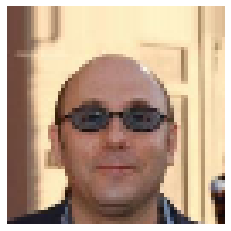

In [ ]:
# 첫번째 이미지 출력
import matplotlib.pyplot as plt

for x in dataset:
  plt.axis('off')
  plt.imshow((x.numpy()*255).astype('int32')[0])

  break

### GAN 판별자 네트워크
Conv2D(filters=, kernel_size=, strides=, padding=)

  - filters: 출력의 채널 크기를 지정합니다. (nums, width, height, filters)
  - kernel_size: 합성곱 행렬의 크기를 지정합니다.
  - stides: 합성곱 행렬의 1 Step Size를 지정합니다.
  - padding: same → Input의 각 변에 padding을 추가합니다. 이 때, 입력의 width, height와 출력의 width, height가 같아집니다.

https://zzsza.github.io/data/2018/02/23/introduction-convolution/

In [ ]:
# Stride : 이미지를 횡단할 때 커널의 스텝 사이즈를 결정
# 기본값은 1이지만 보통 Max Pooling과 비슷하게 이미지를 '다운샘플링' 하기 위해 Stride를 2로 사용할 수 있다

from tensorflow.keras import layers

discriminator = keras.Sequential([
    keras.Input(shape=(64,64,3)),
    layers.Conv2D(filters=64, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),  # alpha : 기울기의 정도
    layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),  # 백터화
    layers.Dropout(0.2),   # 20% 를 dropout
    layers.Dense(units=1, activation='sigmoid'),
], name='discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)            

### GAN 생성자 네트워크

In [ ]:
latent_dim = 128

generator = keras.Sequential([
    keras.Input(shape=(latent_dim, )),
    layers.Dense(units=8*8*128),  # 잠재공간 생성
    layers.Reshape((8,8,128)),
    layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(filters=256, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(filters=512, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(filters=3, kernel_size=5, padding='same', activation='sigmoid'),
], name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 32, 32, 256)       0 

### 적대 네트워크 (GAN 모델)

* Step One
 - batch_size 입력으로 받은 real_images의 개수를 저장

 - random_latent_vectors batch_size 만큼 generator에 입력할 latent_vector를 생성\
ex) batch_size=512, latent_vector=128 일 때, (512, 128) 크기의 random vector 생성

 - generated_images generator에 latent_vector를 입력하여 가짜 이미지 생성

 - combined_images 실제 이미지와 가짜 이미지를 연결하여 하나의 텐서로 만듬
   - labels 실제 이미지와 가짜 이미지는 모두 batch_size만큼 있다.\
   실제 이미지에는 1을, 가짜 이미지에는 0을 할당할 텐서를 만든다.

 - labels += 0.05 * tf.random.uniform(tf.shape(labels))
   - labels는 현재 0 또는 1의 값을 가지고 있다.\
   여기에 0.05*Random(0~1) 값을 더하여 약간씩 다르게 한다. 
   - discriminator의 학습에만 사용되는데 Noise를 추가함으로 판별능력을 키울 수 있다.

* Step Two
 - 이전 GAN 의 가중치 갱신부와 같다.

 - 다만, 이전에 선언한 labels 는 discriminator에 새로 선언한 정수만을 가지고 있는 misleading_labels 는 generator의 학습에 사용된다는 점이 다르다.

 - d_loss와 g_loss를 반환하고 함수를 종료한다.

In [ ]:
import tensorflow as tf

class GAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super().__init__()   # 상속받은 keras.Model Class 의 생성자 실행
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim
    self.d_loss_metric = keras.metrics.Mean(name='d_loss')
    self.g_loss_metric = keras.metrics.Mean(name='g_loss')

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  # property decorator 로 메소드를 속성으로 선언
  # compile 에서 선언한 d_loss_metric 와 g_loss_metric 속성을 List 로 반환
  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_images):
    # Sample random points in the latent space
    batch_size = tf.shape(real_images)[0]   # real_images 의 개수를 저장
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # generator 에 latent_vector 를 입력하여 가짜 이미지를 생성
    generated_images = self.generator(random_latent_vectors)

    # 실제 이미지와 가짜 이미지를 연결하여 하나의 텐서로 만듬
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # 실제 이미지와 가짜 이미지는 모두 batch_size 만큼 있다
    # 실제 이미지에는 1을, 가짜 이미지에는 0을 할당할 텐서 생성
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
        axis=0)

    # Noise 를 추가함으로 판별능력을 더 키울 수 있게 함
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    # Train the discriminator
    with tf.GradientTape() as tape:
        predictions = self.discriminator(combined_images)
        d_loss = self.loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
        zip(grads, self.discriminator.trainable_weights)
    )

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # Assemble labels that say 'all real images'
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (discriminator 의 가중치가 업데이트 되지 않도록 해야한다)
    # generator 의 학습을 discriminator 는 몰라야 한다
    with tf.GradientTape() as tape:
        predictions = self.discriminator(
            self.generator(random_latent_vectors))
        g_loss = self.loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(
        zip(grads, self.generator.trainable_weights))

    # Update metrics
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {'d_loss' : self.d_loss_metric.result(),
            'g_loss' : self.g_loss_metric.result()}

**훈련 과정 동안에 이미지를 생성하기 위한 콜백**

Callback 사용하기 - 커스텀 콜백 / 모델 학습 / 평가<br>
https://littlefoxdiary.tistory.com/87

keras.callbacks.Callback
콜백 객체를 생성

API에 명시된 함수를 작성하면, 지정한 학습과정에서 콜백함수를 호출 할 수 있으며 코드에서는 on_epoch_end 즉, epoch가 끝날 때 마다 함수를 실행

In [ ]:
class GANMonitor(keras.callbacks.Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):   # epoch 가 끝날 때마다 함수 실행
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()

    for i in range(self.num_img):
      img = keras.utils.array_to_img(generated_images[i])
      img.save(f"generated_img_{epoch:03d}_{i}.png")

In [ ]:
# GAN 모델 컴파일하고 훈련하기
epochs = 30

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy()
)
       
gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

Epoch 1/30
6332/6332 [==============================] - 1867s 292ms/step - d_loss: 0.6087 - g_loss: 1.2417
Epoch 2/30
6332/6332 [==============================] - 1850s 292ms/step - d_loss: 0.6605 - g_loss: 1.0437
Epoch 3/30
6332/6332 [==============================] - 1849s 292ms/step - d_loss: 0.6677 - g_loss: 0.9892
Epoch 4/30
6332/6332 [==============================] - 1852s 292ms/step - d_loss: 0.6546 - g_loss: 1.0742
Epoch 5/30
6332/6332 [==============================] - 1854s 293ms/step - d_loss: 0.6472 - g_loss: 1.0506
Epoch 6/30
6332/6332 [==============================] - 1853s 293ms/step - d_loss: 0.6532 - g_loss: 0.9992
Epoch 7/30
6332/6332 [==============================] - 1852s 293ms/step - d_loss: 0.6608 - g_loss: 0.9728
Epoch 8/30
6332/6332 [==============================] - 1852s 293ms/step - d_loss: 0.6695 - g_loss: 0.9205
Epoch 9/30
6332/6332 [==============================] - 1852s 292ms/step - d_loss: 0.6767 - g_loss: 0.9111
Epoch 10/30
6332/6332 [==============

KeyboardInterrupt: ignored